In [3]:
import simpsom as sps
from simpsom import SOMNet
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np


2023-04-14 16:44:22.444 | INFO     | simpsom.network:__init__:144 - Periodic Boundary Conditions active.
2023-04-14 16:44:22.444 | INFO     | simpsom.network:__init__:154 - Hexagonal topology.
2023-04-14 16:44:22.445 | WARNING  | simpsom.network:_set_weights:224 - Please be sure that the data have been standardized before using PCA.
2023-04-14 16:44:22.445 | INFO     | simpsom.network:_set_weights:227 - The weights will be initialized with PCA.
2023-04-14 16:44:22.447 | INFO     | simpsom.network:train:392 - The map will be trained with the batch algorithm.
2023-04-14 16:44:22.648 | INFO     | simpsom.network:project_onto_map:595 - Projected coordinates will be saved to:
././som_projected.npy


(1797,)
(100, 100)
(100,)


/Users/bandelol/Library/CloudStorage/OneDrive-UniversitaetBern/Documents/GIUB/code/simpsom/simpsom/network.py:719: RuntimeWarning: invalid value encountered in divide
  trans_mat /= np.sum(trans_mat, axis=1)[:, None]


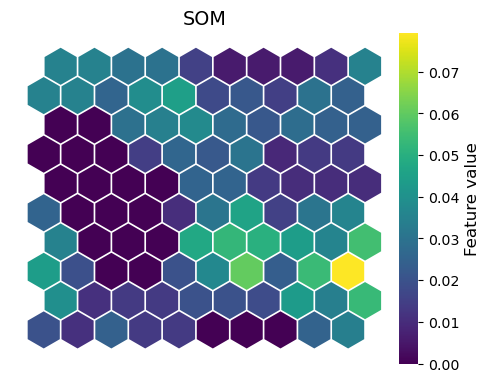

In [4]:
data = load_digits().data
nx, ny = 10, 10
net = SOMNet(nx, ny, data, init='pca', PBC=True, inner_dist_type='cartesian', neighborhood_fun='mexican_hat')
net.train()
projected = net.project_onto_map(data)
distances = net.neighborhoods.distances
theta = net.theta
a = np.random.randint(nx * ny)
populations = net.compute_populations()

# fig, ax = net.plot_on_map(populations)

residence_times = net.compute_residence_time('max', 1)
# fig, ax = net.plot_on_map(residence_times, 1.0)

trans_mat = net.compute_transmat()
print(net.bmus.shape)
print(trans_mat.shape)
print(np.diag(trans_mat).shape)
fig, ax = net.plot_on_map(np.diag(trans_mat), 1.0)
# plt.show()

In [7]:
from sklearn.decomposition import PCA as pca
from scipy import linalg


In [8]:
pca_obj = pca(20, whiten=True).fit(data)

In [9]:
data_trans = pca_obj.transform(data)

In [10]:
data_trans.shape

(1797, 20)

In [23]:
from nptyping import NDArray


# def OPP_fast(X: NDArray, lag_max: int = 20) -> NDArray:
X = data_trans
lag_max = 15
n_pcas = X.shape[1]
autocorrs = []
for j in range(lag_max):
    autocorrs.append(
        np.cov(X[j:], np.roll(X, j, axis=0)[j:], rowvar=False)[n_pcas:, :n_pcas]
    )

autocorrs = np.asarray(autocorrs)
M = autocorrs[0] + np.sum(
    [autocorrs[i] + autocorrs[i].transpose() for i in range(1, lag_max)], axis=0
)

invsqrtC0 = linalg.inv(linalg.sqrtm(autocorrs[0]))
symS = invsqrtC0.T @ M @ invsqrtC0
eigenvals, eigenvecs = linalg.eigh(symS)
OPPs = autocorrs[0] @ (invsqrtC0 @ eigenvecs.T)
idx = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[idx]
OPPs = OPPs[idx]


In [26]:
OPPs.shape

(20, 20)

In [30]:
pca_obj.inverse_transform(OPPs).shape

(20, 64)

In [32]:
X.shape

(1797, 20)

In [53]:
X_proj = (X @ OPPs)

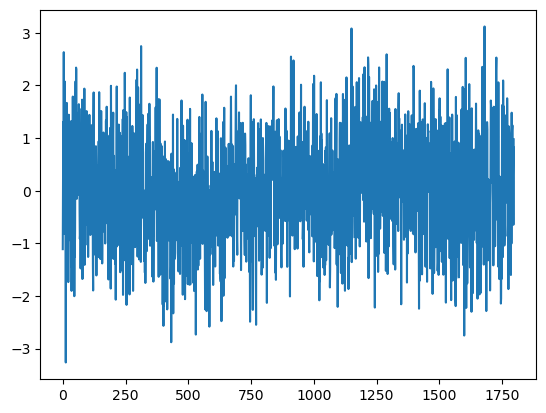

In [54]:
plt.plot(X_proj[:, 2])

In [55]:
data_recov = pca_obj.inverse_transform(X_proj @ OPPs.T)

In [56]:
np.mean(np.abs(data - data_recov))

0.9475195206998265

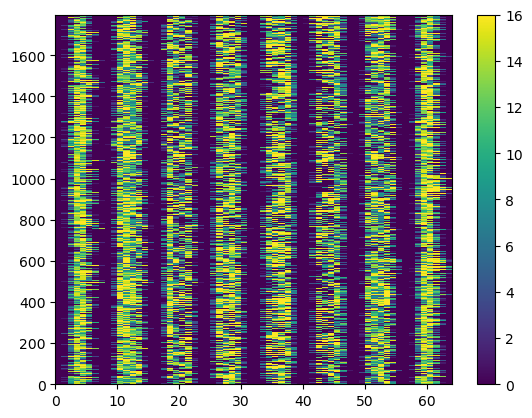

In [59]:
plt.pcolormesh(data)
plt.colorbar()

In [ ]:
plt.pcolormesh(data)
plt.colorbar()